In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import keras
from keras import layers

In [8]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [13]:
from stacked_mnist import StackedMNISTData, DataMode
from tensorflow import keras

generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
x_test = x_test[:, :, :, [0]]
y_test = keras.utils.to_categorical((y_test % 10).astype(np.int), 10)

In [14]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
469/469 [==============================] - 37s 77ms/step - loss: 0.0810 - val_loss: 0.0789
Epoch 2/10
469/469 [==============================] - 42s 89ms/step - loss: 0.0789 - val_loss: 0.0767
Epoch 3/10
469/469 [==============================] - 34s 73ms/step - loss: 0.0773 - val_loss: 0.0753
Epoch 4/10
469/469 [==============================] - 39s 83ms/step - loss: 0.0761 - val_loss: 0.0747
Epoch 5/10
469/469 [==============================] - 38s 82ms/step - loss: 0.0750 - val_loss: 0.0732
Epoch 6/10
469/469 [==============================] - 36s 76ms/step - loss: 0.0740 - val_loss: 0.0723
Epoch 7/10
469/469 [==============================] - 38s 81ms/step - loss: 0.0730 - val_loss: 0.0716
Epoch 8/10
469/469 [==============================] - 37s 79ms/step - loss: 0.0724 - val_loss: 0.0705
Epoch 9/10
469/469 [==============================] - 36s 76ms/step - loss: 0.0716 - val_loss: 0.0698
Epoch 10/10
469/469 [==============================] - 39s 83ms/step - loss: 0.070

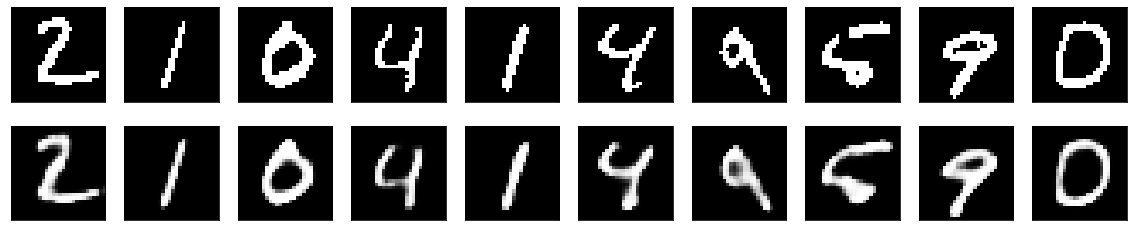

In [15]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
from verification_net import VerificationNet

net = VerificationNet(force_learn=False, file_name="../models/verification_model")
img, labels = generator.get_random_batch(training=False, batch_size=25000)
decoded_imgs = autoencoder.predict(img)
_, acc_ae = net.check_predictability(data=decoded_imgs, correct_labels=labels)
_, acc_orig = net.check_predictability(data=img, correct_labels=labels)
print(f"Accuracy AE: {100 * acc_ae:.2f}%")
print(f"Accuracy Original: {100 * acc_orig:.2f}%")


/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy AE: 83.59%
Accuracy Original: 95.95%
